In this notebook we will perform   
* Exploratory Data Analysis       
* Data cleaning & Natural Language processing        
    * Selecting relevant columns   
    * Spelling correction   
    * Remove html , xml tags   
    * Convert short forms
    * Remove special characters   
    * Remove stop words   
    * Stemming,Lemmatization       
* Visualization   
    * word clouds   
    * Horizontal bar plots of words   
    * Frequency distribution plots
    
Note:   
* Spell check and correction will take considerable long time   
* Stemming, Lemmatization is not required for Word2Vec vectorization. But required for other BOW, TFIDF   
* The meaning of the tweets is more important hence choosing lemmatization instead of stemming (doesnt take semantic meaning of the words in to consideration)  

In [1]:
# Load libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob 
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

### Load the data

In [2]:
# source : https://www.kaggle.com/c/nlp-getting-started/data
tweets_train_data = pd.read_csv('train.csv')
tweets_test_data = pd.read_csv('test.csv')

In [3]:
tweets_train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Columns:**    
**id** - a unique identifier for each tweet     
**text** - the text of the tweet    
**location** - the location the tweet was sent from          
**keyword** - a particular keyword from the tweet    
**target** - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)    

### Exploratory Data Analysis:

In [4]:
print("No.of rows in the data set : {}".format(len(tweets_train_data)))

No.of rows in the data set : 7613


In [5]:
nas = len(tweets_train_data[(tweets_train_data['keyword'].isnull()) | (tweets_train_data['location'].isnull())])
print("Total No.of rows with missing values in 'keyword' or 'location' columns : {}".format(int(nas)))

Total No.of rows with missing values in 'keyword' or 'location' columns : 2533


The data set has only 7613 instances. 61/7613 in keyword column and 2533/7613 instances has missing values. But removing all these rows leads to severe data loss. Hence we will replace the missing values with the word "other"

In [6]:
# Checking for missing value count in each column
print("No.of rows with nan values in keyword : ",tweets_train_data['keyword'].isnull().values.sum())
print("No.of rows with nan values in location : ",tweets_train_data['location'].isnull().values.sum())
print("No.of rows with nan values in text : ",tweets_train_data['text'].isnull().values.sum())
print("No.of rows with nan values in target : ",tweets_train_data['target'].isnull().values.sum())

# Replacing all nan in keyword column with "other"
tweets_train_data['keyword'] = tweets_train_data['keyword'].replace(np.nan, "other")
# Replacing all nan in location column with "other"
tweets_train_data['location'] = tweets_train_data['location'].replace(np.nan, "other")

print("="*50)
print("After imputing the missing values")
print("="*50)
# Checking for missing value count in each column
print("No.of rows with nan values in keyword : ",tweets_train_data['keyword'].isnull().values.sum())
print("No.of rows with nan values in location : ",tweets_train_data['location'].isnull().values.sum())
print("No.of rows with nan values in text : ",tweets_train_data['text'].isnull().values.sum())
print("No.of rows with nan values in target : ",tweets_train_data['target'].isnull().values.sum())

No.of rows with nan values in keyword :  61
No.of rows with nan values in location :  2533
No.of rows with nan values in text :  0
No.of rows with nan values in target :  0
After imputing the missing values
No.of rows with nan values in keyword :  0
No.of rows with nan values in location :  0
No.of rows with nan values in text :  0
No.of rows with nan values in target :  0


In [7]:
print("Unique key words : {}".format(len(tweets_train_data['keyword'].unique())))
print("Unique locations : {}".format(len(tweets_train_data['location'].unique())))

Unique key words : 222
Unique locations : 3342


Number of instances that are flagged as real disaster 3271 , ( 42.96597924602653 %)
Number of instances that are flagged as non real disaster 4342 , ( 57.03402075397347 %)


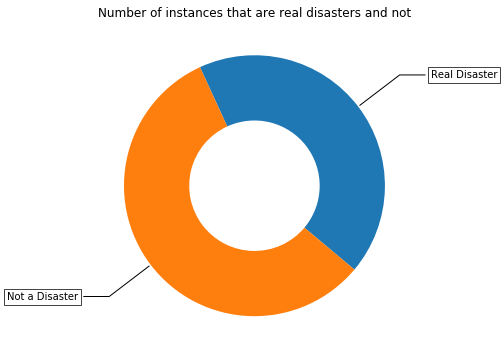

In [8]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
y_value_counts = tweets_train_data['target'].value_counts()
print("Number of instances that are flagged as real disaster", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of instances that are flagged as non real disaster", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Real Disaster", "Not a Disaster"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of instances that are real disasters and not")

plt.show()

**Observation:**    
The data set seems to be fairly balanced data set. Hence, no need for balancing the class lables

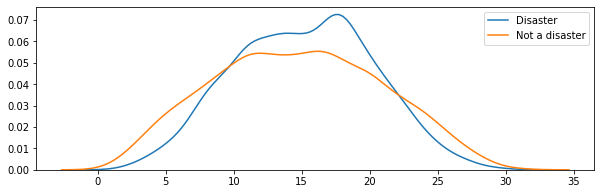

In [9]:
disaster_1_text_word_count = tweets_train_data[tweets_train_data['target']==1]['text'].str.split().apply(len)
disaster_1_text_word_count = disaster_1_text_word_count.values

disaster_0_text_word_count = tweets_train_data[tweets_train_data['target']==0]['text'].str.split().apply(len)
disaster_0_text_word_count = disaster_0_text_word_count.values

plt.figure(figsize=(10,3))
# distribution plot for No.of words in text of disaster '1'
sns.distplot(disaster_1_text_word_count, hist=False, label="Disaster")
# distribution plot for No.of words in text of disaster '0'
sns.distplot(disaster_0_text_word_count, hist=False, label="Not a disaster")
plt.legend()
plt.show()

**Observation:**  There seem to be more number of words in the actual disaster tweets when compared to non disaster tweets

### Data Cleaning & Natural Language Processing

In [11]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer() 

def text_preprocessor(sent):
    """Method takes a phrase, cleans and return the phrase"""
    # Spelling correction
#     sent = TextBlob(sent).correct()
#     sent = str(sent)
    # remove html , xml tags
    sent = BeautifulSoup(sent, 'lxml').get_text()
    sent = re.sub(r"http\S+", " ", sent)         # substitute "http" with " "
    sent = re.sub(re.compile('<.*?>')," ",sent)
    # remove short forms        
    sent = re.sub(r"won't", "will not", sent)    # substitute "won't" with "will not" 
    sent = re.sub(r"can\'t", "can not", sent)    # substitute "can't" with "can not"
    sent = re.sub(r"n\'t", "not", sent)          # substitute "n't" with "not"
    sent = re.sub(r"rt", "right", sent)          # substitute "r't" with "right"
    sent = re.sub(r"\'re", "are", sent)          # substitute "'re" with "are"
    sent = re.sub(r"\'s", "is", sent)            # substitute "'s" with "is" 
    sent = re.sub(r"\'d", "would", sent)         # substitute "'d"  with " would"
    sent = re.sub(r"\'ll", "will", sent)         # substitute "'ll" with " will"
    sent = re.sub(r"\'t", "not", sent)           # substitute "'t" with " not"
    sent = re.sub(r"\'ve", "have", sent)         # substitute "'ve" with " have"
    sent = re.sub(r"\'m", "am", sent)            # substitute "'m" with " am"          
    sent = re.sub("\S*\d\S*", " ", sent).strip() # substitute "\S*\d\S" with " " and strip the s
    sent = sent.strip()
    # remove special characters
    sent = re.sub('[^A-Za-z0-9]+'," ", sent)     # remove all special characters
    sent = re.sub(r'[?|!\'|"|#]'," ",sent)       # remove all special characters
    sent = re.sub(r'[.|,|)|(|\|/]'," ",sent)     # remove all special characters
    sent = re.sub('\\r|\\n|\\"'," ",sent)        # remove all special characters
    # convert to lower case & remove stop words
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stop)
    # stemming lemmatization
    if len(sent.split(" ")) > 1:
        # Lemmatization
        sent = ' '.join(lemmatizer.lemmatize(s) for s in sent.split()) 
        # Stemming
        # sent = ' '.join(stemmer.stem(s) for s in sent.split())   
    return sent

In [12]:
# Cleaning the key word column
tweets_train_data['keyword'] = [text_preprocessor(i) for i in tqdm(tweets_train_data['keyword'])]
tweets_train_data['text'] = [text_preprocessor(i) for i in tqdm(tweets_train_data['text'])]

In [13]:
# Thanks to the author
# code taken from https://www.geeksforgeeks.org/generating-word-cloud-python/
# code taken from https://www.geeksforgeeks.org/python-textblob-correct-method/

def word_clouder(column):
    """Method takes a text column and returns a word cloud object"""
    word_corpus = ' '     
    # iterate through the csv file 
    for val in column: 
        val = str(val) 
        tokens = val.split() 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        for words in tokens: 
            word_corpus = word_corpus + words + ' '
    
    word_cloud = WordCloud(width = 800,
                           height = 800,
                           background_color ='white',
                           collocations=False,
                           min_font_size = 10).generate(word_corpus)
    return word_cloud


(-0.5, 799.5, 799.5, -0.5)

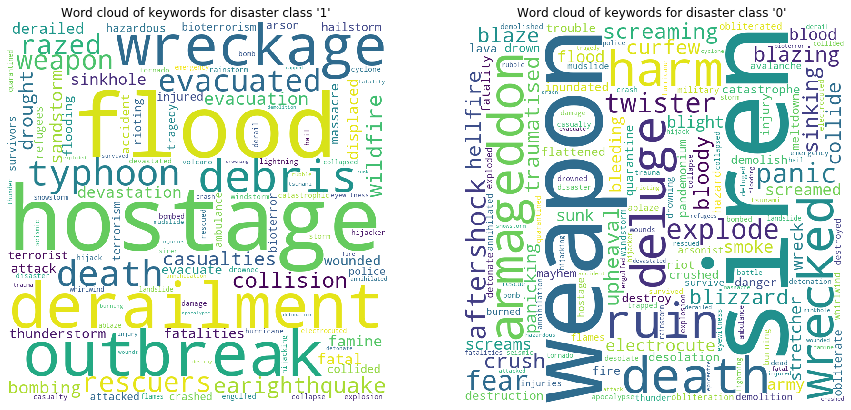

In [14]:
# Word cloud of keywords which belong actual disaster class '1'
keyword_wordcloud_1 = word_clouder(tweets_train_data[tweets_train_data['target'] == 1]['keyword'])

# Word cloud of keywords which belong actual disaster class '0'
keyword_wordcloud_0 = word_clouder(tweets_train_data[tweets_train_data['target'] == 0]['keyword'])

# Word cloud of location which belong to actual disaster class '1'
location_wordcloud_1 = word_clouder(tweets_train_data[tweets_train_data['target'] == 1]['location'])

# Word cloud of location which belong to actual disaster class '0'
location_wordcloud_0 = word_clouder(tweets_train_data[tweets_train_data['target'] == 0]['location'])

# Word cloud of text which belong actual disaster class '1'
text_wordcloud_1 = word_clouder(tweets_train_data[tweets_train_data['target'] == 1]['text'])

# Word cloud of text which belong actual disaster class '0'
text_wordcloud_0 = word_clouder(tweets_train_data[tweets_train_data['target'] == 0]['text'])

# subplot layout                 
fig, (a,b) = plt.subplots(1,2,figsize=(15,15))

a.set_title("Word cloud of keywords for disaster class '1' ")
a.figsize = (5,5)
a.imshow(keyword_wordcloud_1) 
a.axis("off") 

b.set_title("Word cloud of keywords for disaster class '0' ")
b.figsize = (5,5)
b.imshow(keyword_wordcloud_0) 
b.axis("off")

**Observation:**   
* From the above 2 word clouds the instances belonging to the disaster class have higher frequency for the words like flood, outbreak, typhoon, debris. These words resemble a situation more of a natural disaster   
* Similarly in the word cloud for not a disaster there are more occurances of words like weapon, siren, death etc which resemble situations like human imposed disaster situations

(-0.5, 799.5, 799.5, -0.5)

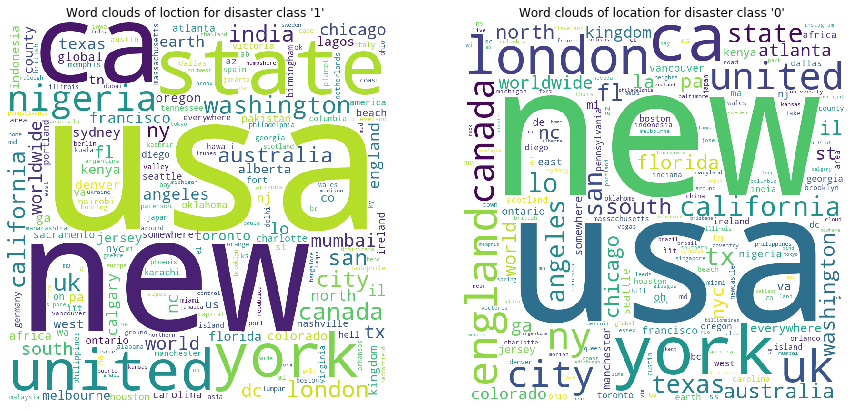

In [15]:
# subplot layout                 
fig, (c,d) = plt.subplots(1,2,figsize=(15,15))

# sub plot c
c.set_title("Word clouds of loction for disaster class '1' ")
c.figsize = (5,5)
c.imshow(location_wordcloud_1) 
c.axis("off")

# sub plot d
d.set_title("Word clouds of location for disaster class '0' ")
d.figsize = (5,5)
d.imshow(location_wordcloud_0) 
d.axis("off")

**Observation:**  
* From the above word clouds there seem to be more natural calamities in USA, california, newyork   
* Similarly there are events in USA, ca, london 

(-0.5, 799.5, 799.5, -0.5)

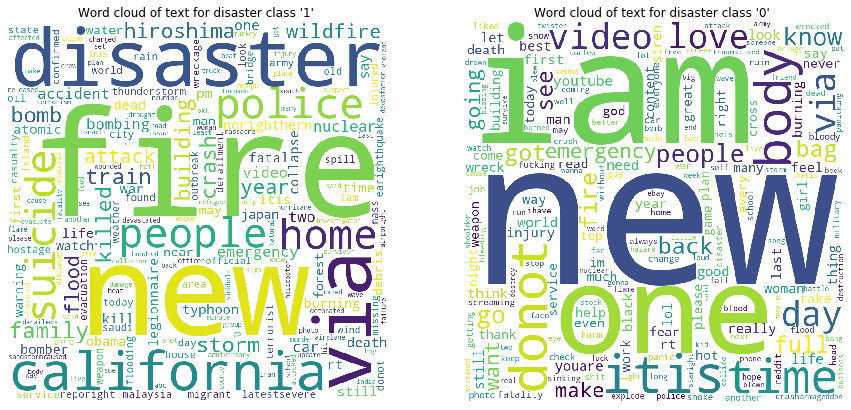

In [16]:
# subplot layout                 
fig, (e,f) = plt.subplots(1,2,figsize=(15,15))

e.set_title("Word cloud of text for disaster class '1' ")
e.figsize = (5,5)
e.imshow(text_wordcloud_1) 
e.axis("off") 

f.set_title("Word cloud of text for disaster class '0' ")
f.figsize = (5,5)
f.imshow(text_wordcloud_0) 
f.axis("off")

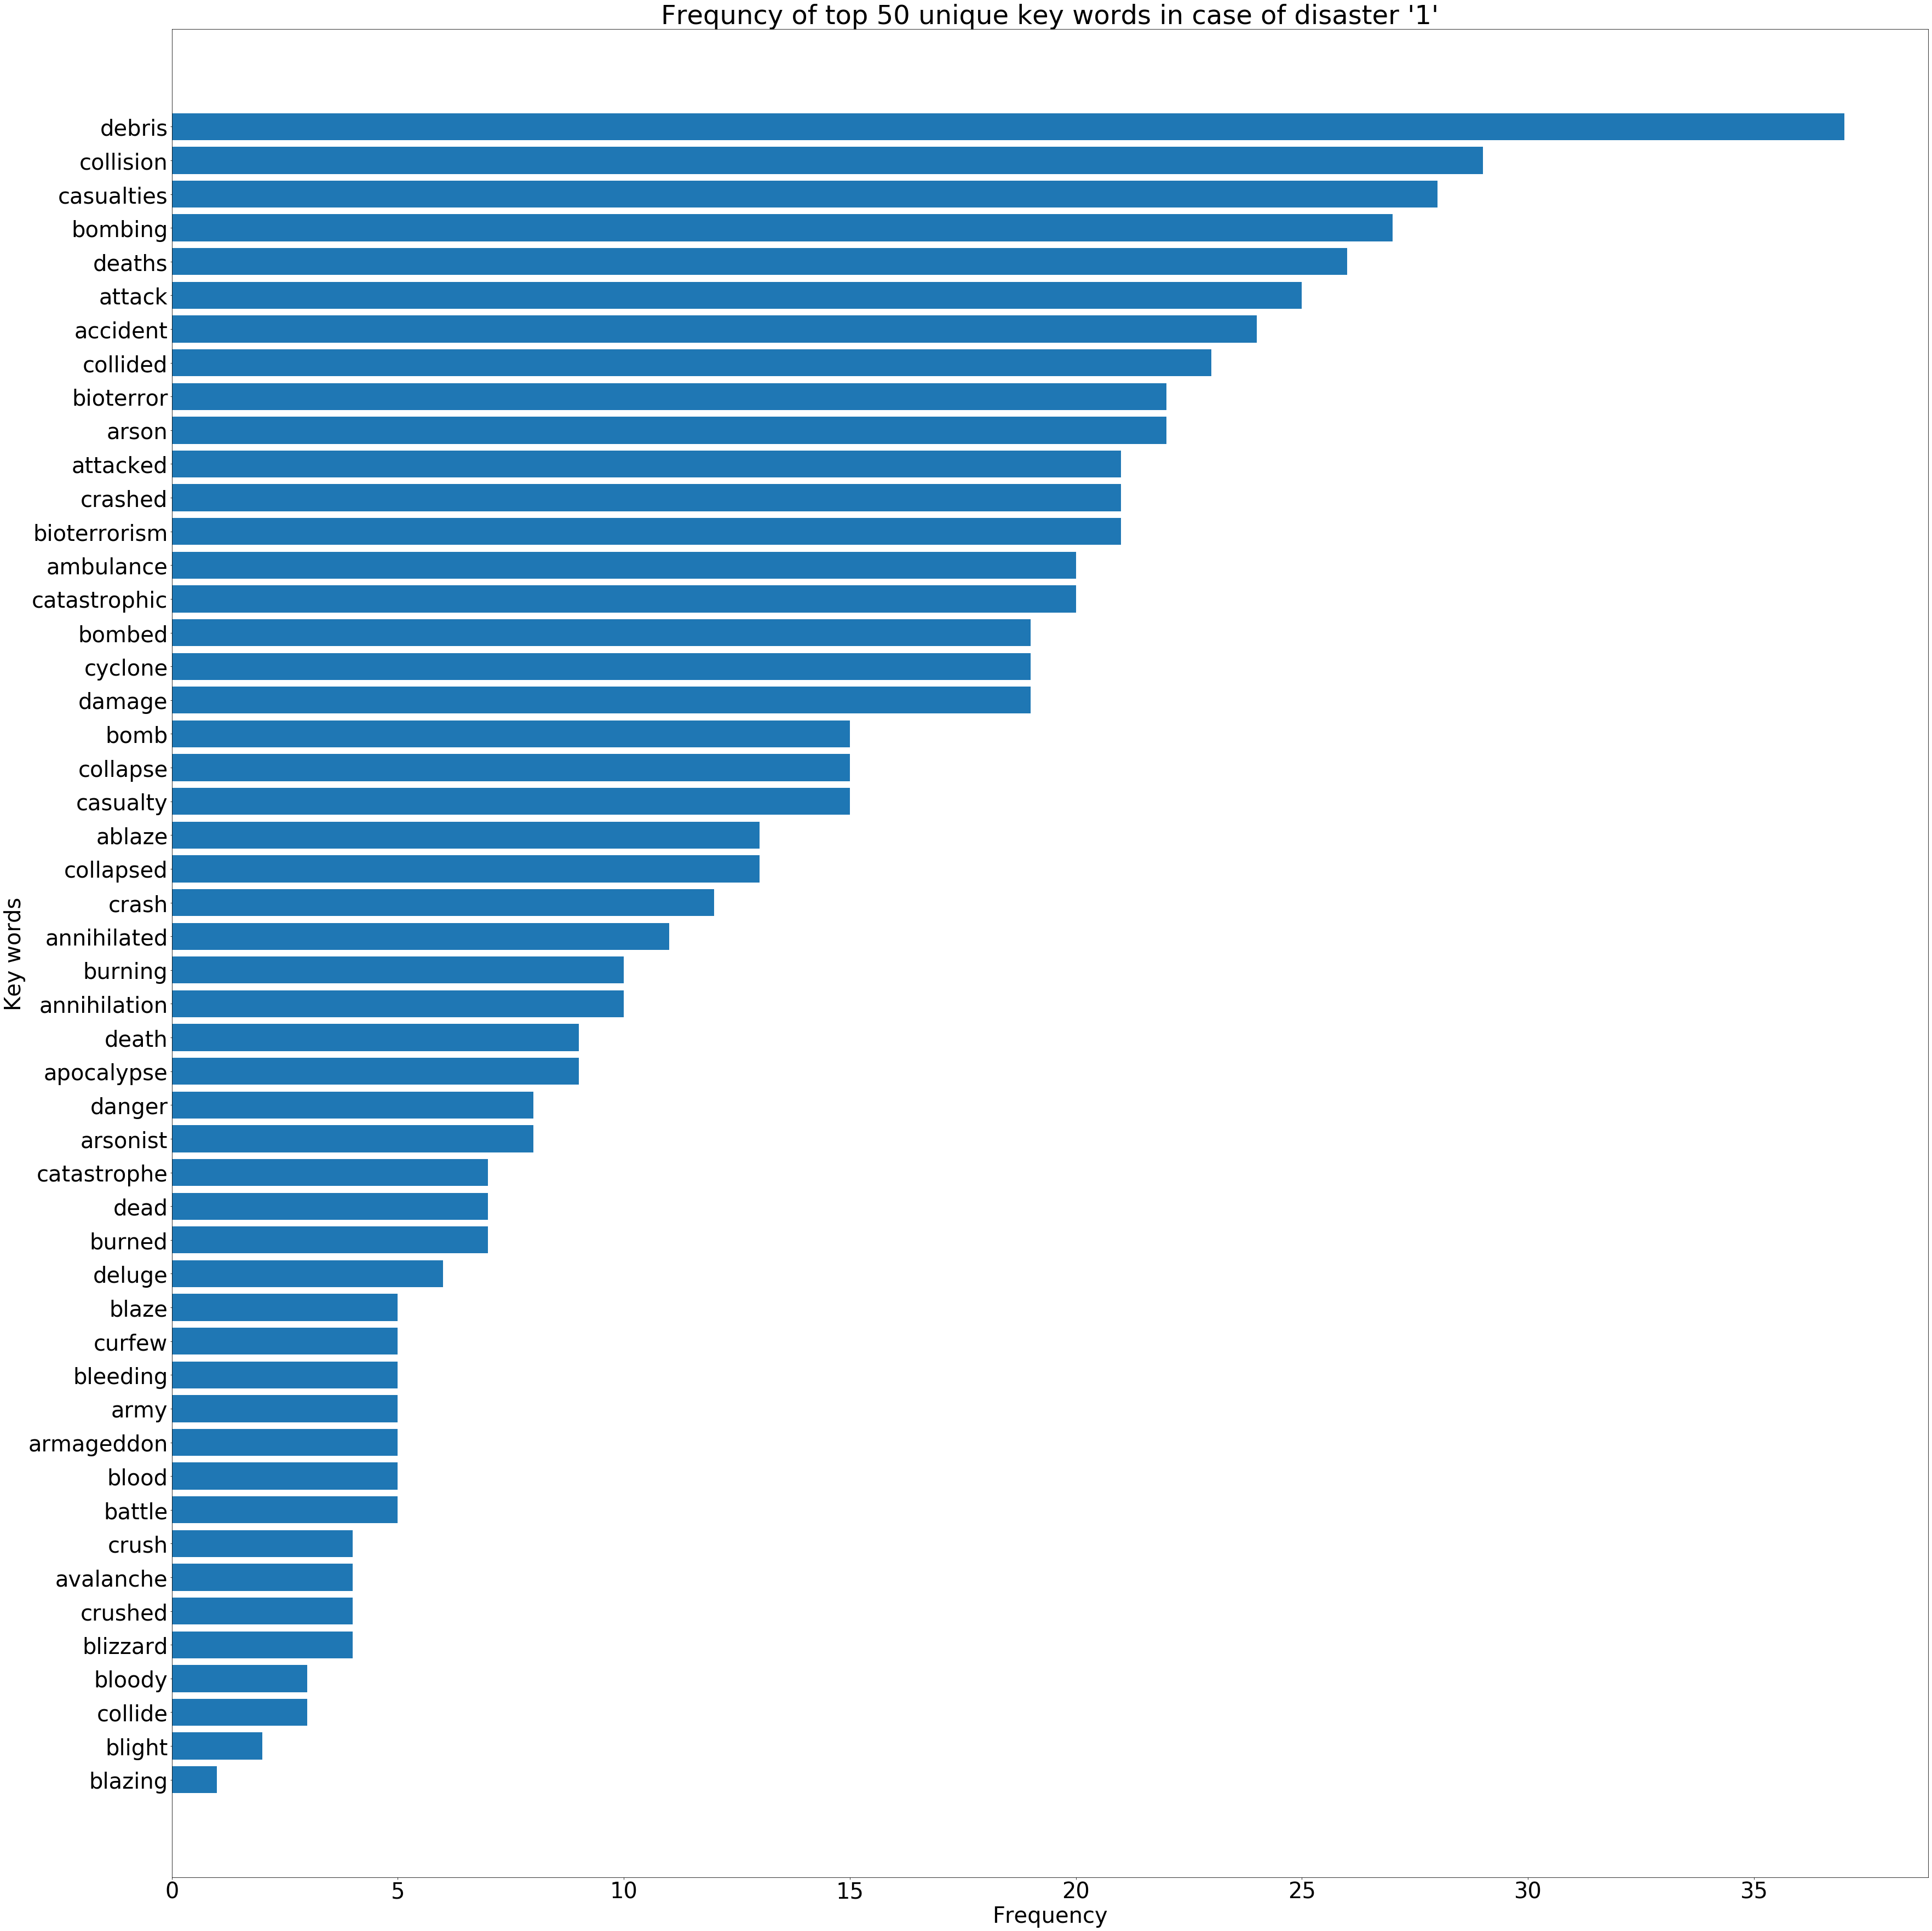

In [17]:
# Frequency plots of unique keywords for disaster class '1'
keyword_frequencies = [i for i in tweets_train_data[tweets_train_data['target'] == 1]['keyword']]
keyword_frequencies = " ".join(keyword_frequencies)
keyword_frequencies = dict(Counter(keyword_frequencies.split()))
keyword_frequencies_df = pd.DataFrame(columns = ['words', 'counts']) 
keyword_frequencies_df['words'] = keyword_frequencies.keys()
keyword_frequencies_df['counts'] = keyword_frequencies.values()
# keyword_frequencies_df.sort_values(by='counts')
# Top 50 keywords and their frequencies 
df = keyword_frequencies_df.iloc[:50,:].sort_values(by='counts')

words = df['words']
y_pos = np.arange(len(words))
count = df['counts']
plt.figure(figsize=(50,50))
font = {'size'   : 40}
plt.rc('font', **font)
plt.barh(y_pos, count,align='center')
plt.yticks(y_pos, words)
plt.xlabel("Frequency")
plt.ylabel("Key words")
plt.title("Frequncy of top 50 unique key words in case of disaster '1'")

plt.tight_layout()
plt.show()

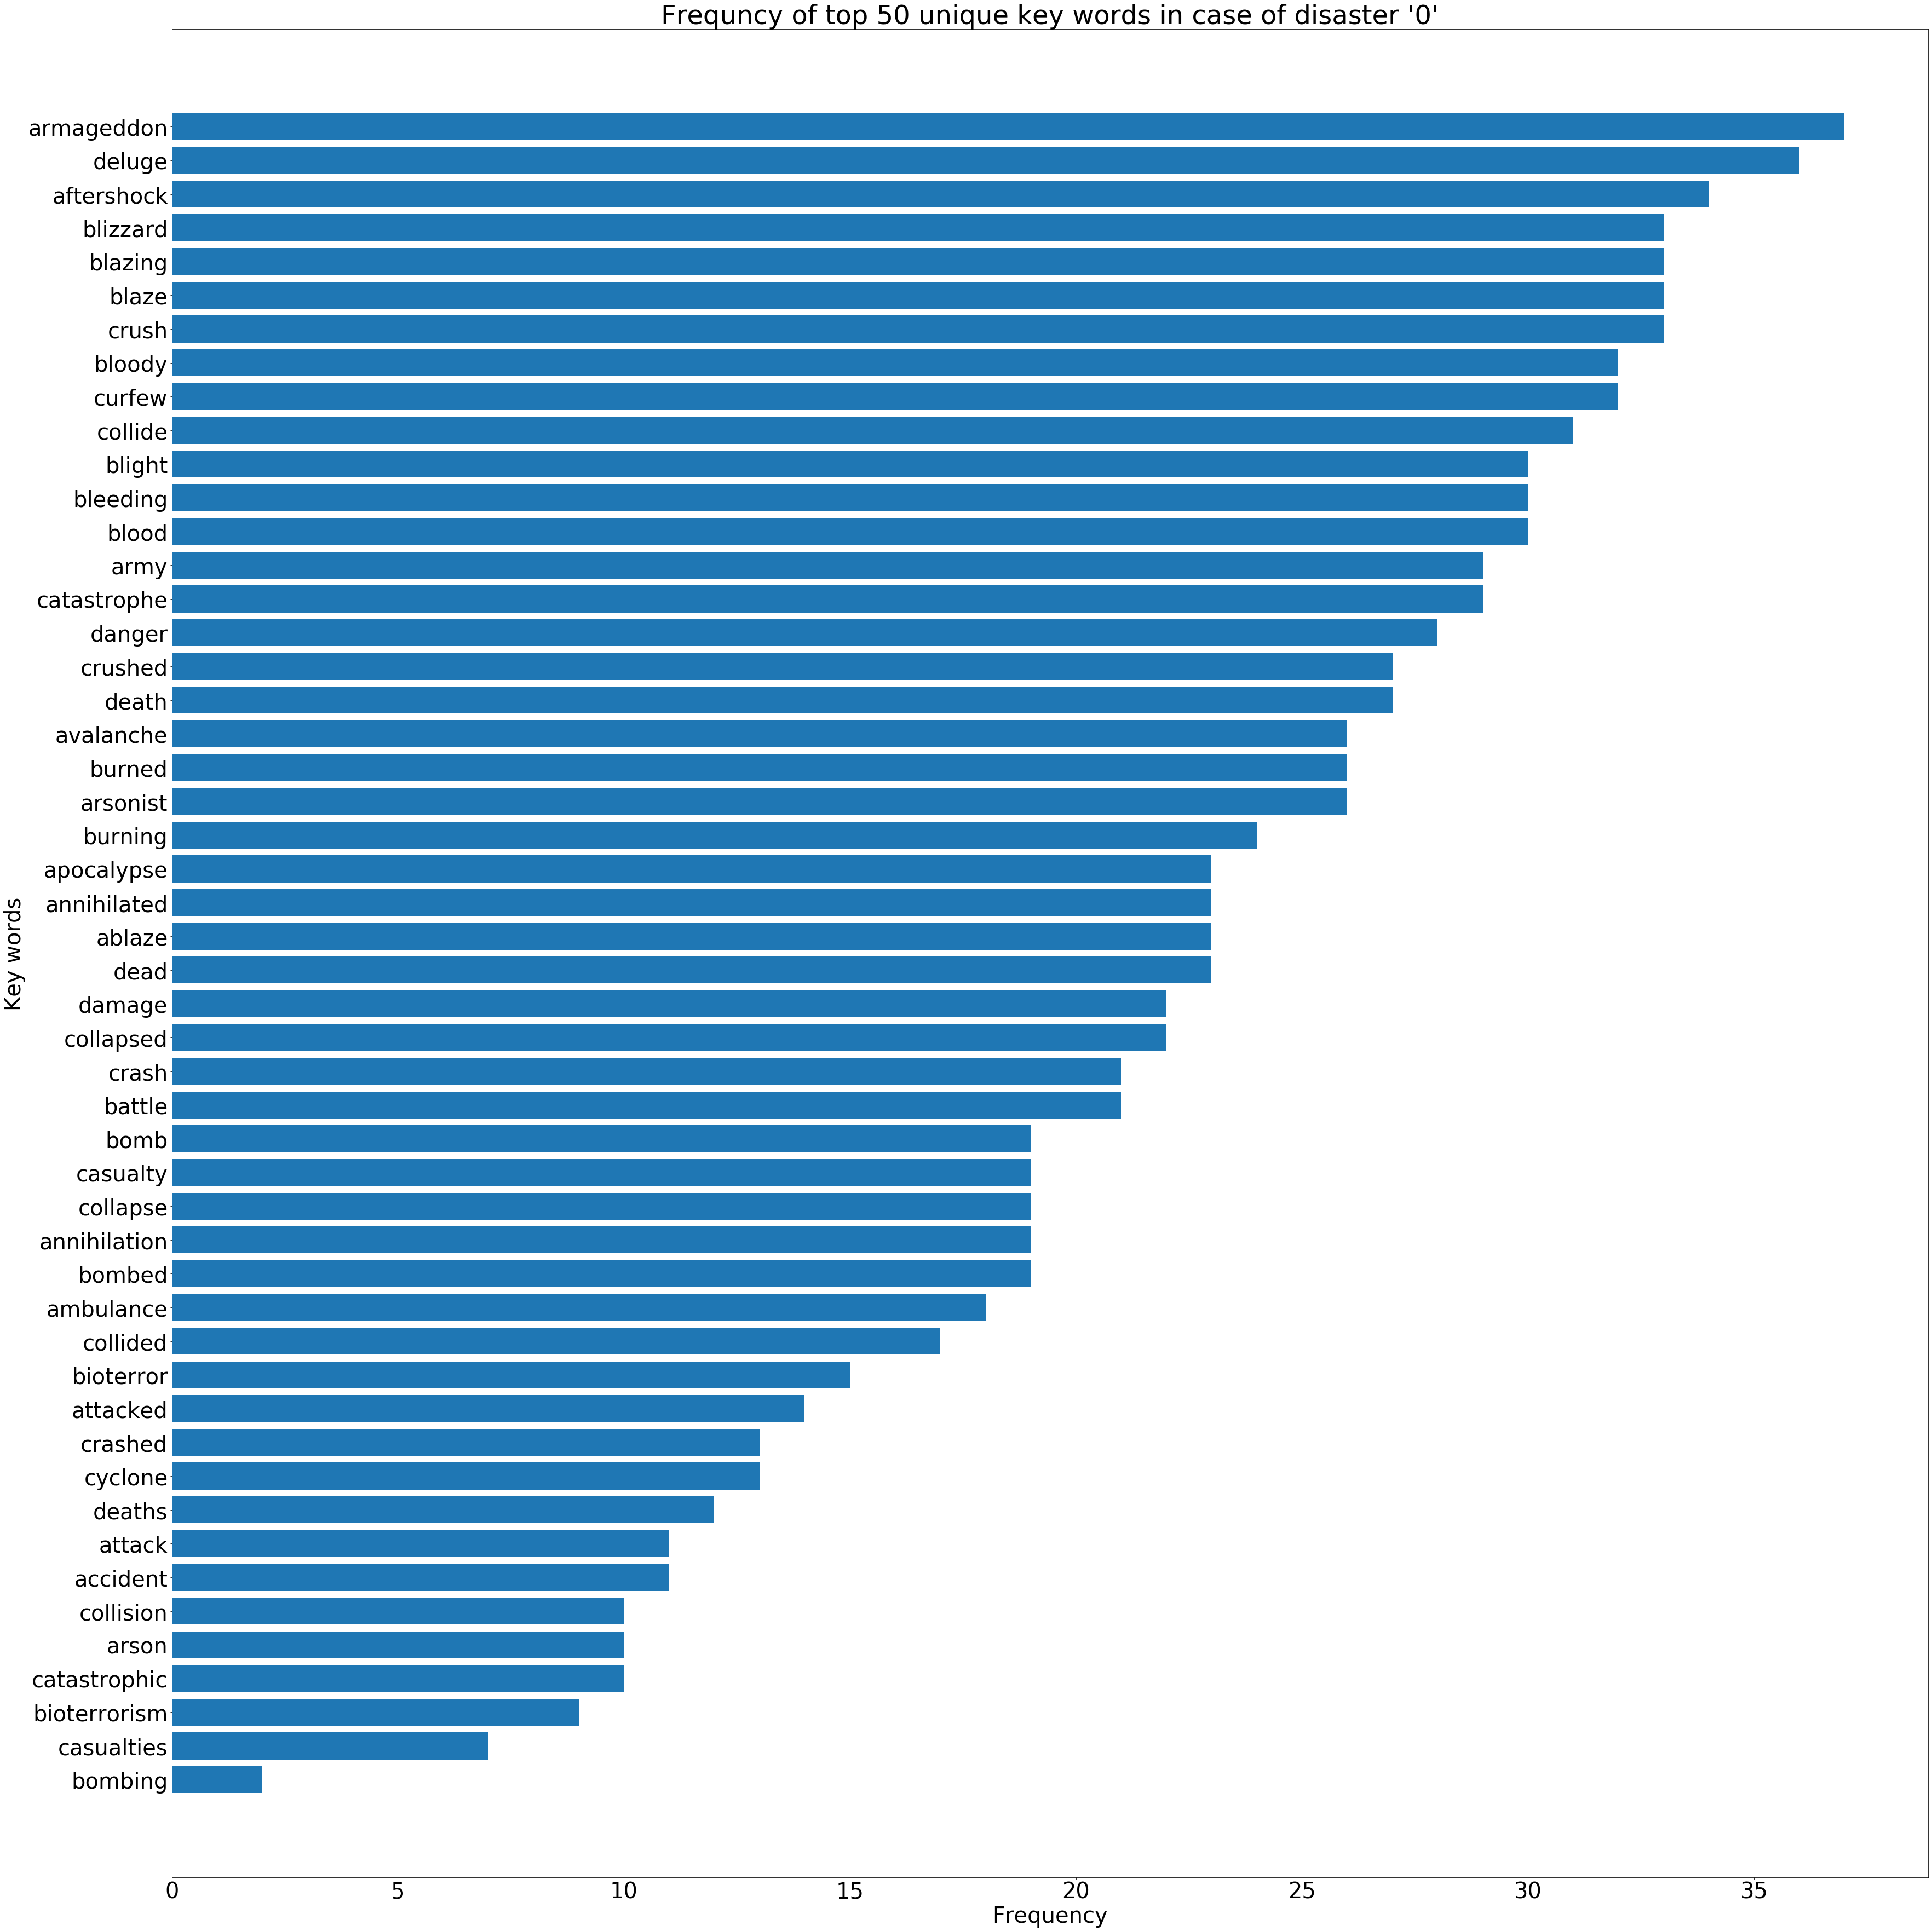

In [18]:
# Frequency plots of unique keywords for disaster class '0'
keyword_frequencies = [i for i in tweets_train_data[tweets_train_data['target'] == 0]['keyword']]
keyword_frequencies = " ".join(keyword_frequencies)
keyword_frequencies = dict(Counter(keyword_frequencies.split()))
keyword_frequencies_df = pd.DataFrame(columns = ['words', 'counts']) 
keyword_frequencies_df['words'] = keyword_frequencies.keys()
keyword_frequencies_df['counts'] = keyword_frequencies.values()
# keyword_frequencies_df.sort_values(by='counts')
# Top 50 keywords and their frequencies 
df = keyword_frequencies_df.iloc[:50,:].sort_values(by='counts')

words = df['words']
y_pos = np.arange(len(words))
count = df['counts']
plt.figure(figsize=(50,50))
plt.barh(y_pos, count,align='center')
plt.yticks(y_pos, words)
plt.xlabel("Frequency")
plt.ylabel("Key words")
plt.title("Frequncy of top 50 unique key words in case of disaster '0'")

plt.tight_layout()
plt.show()

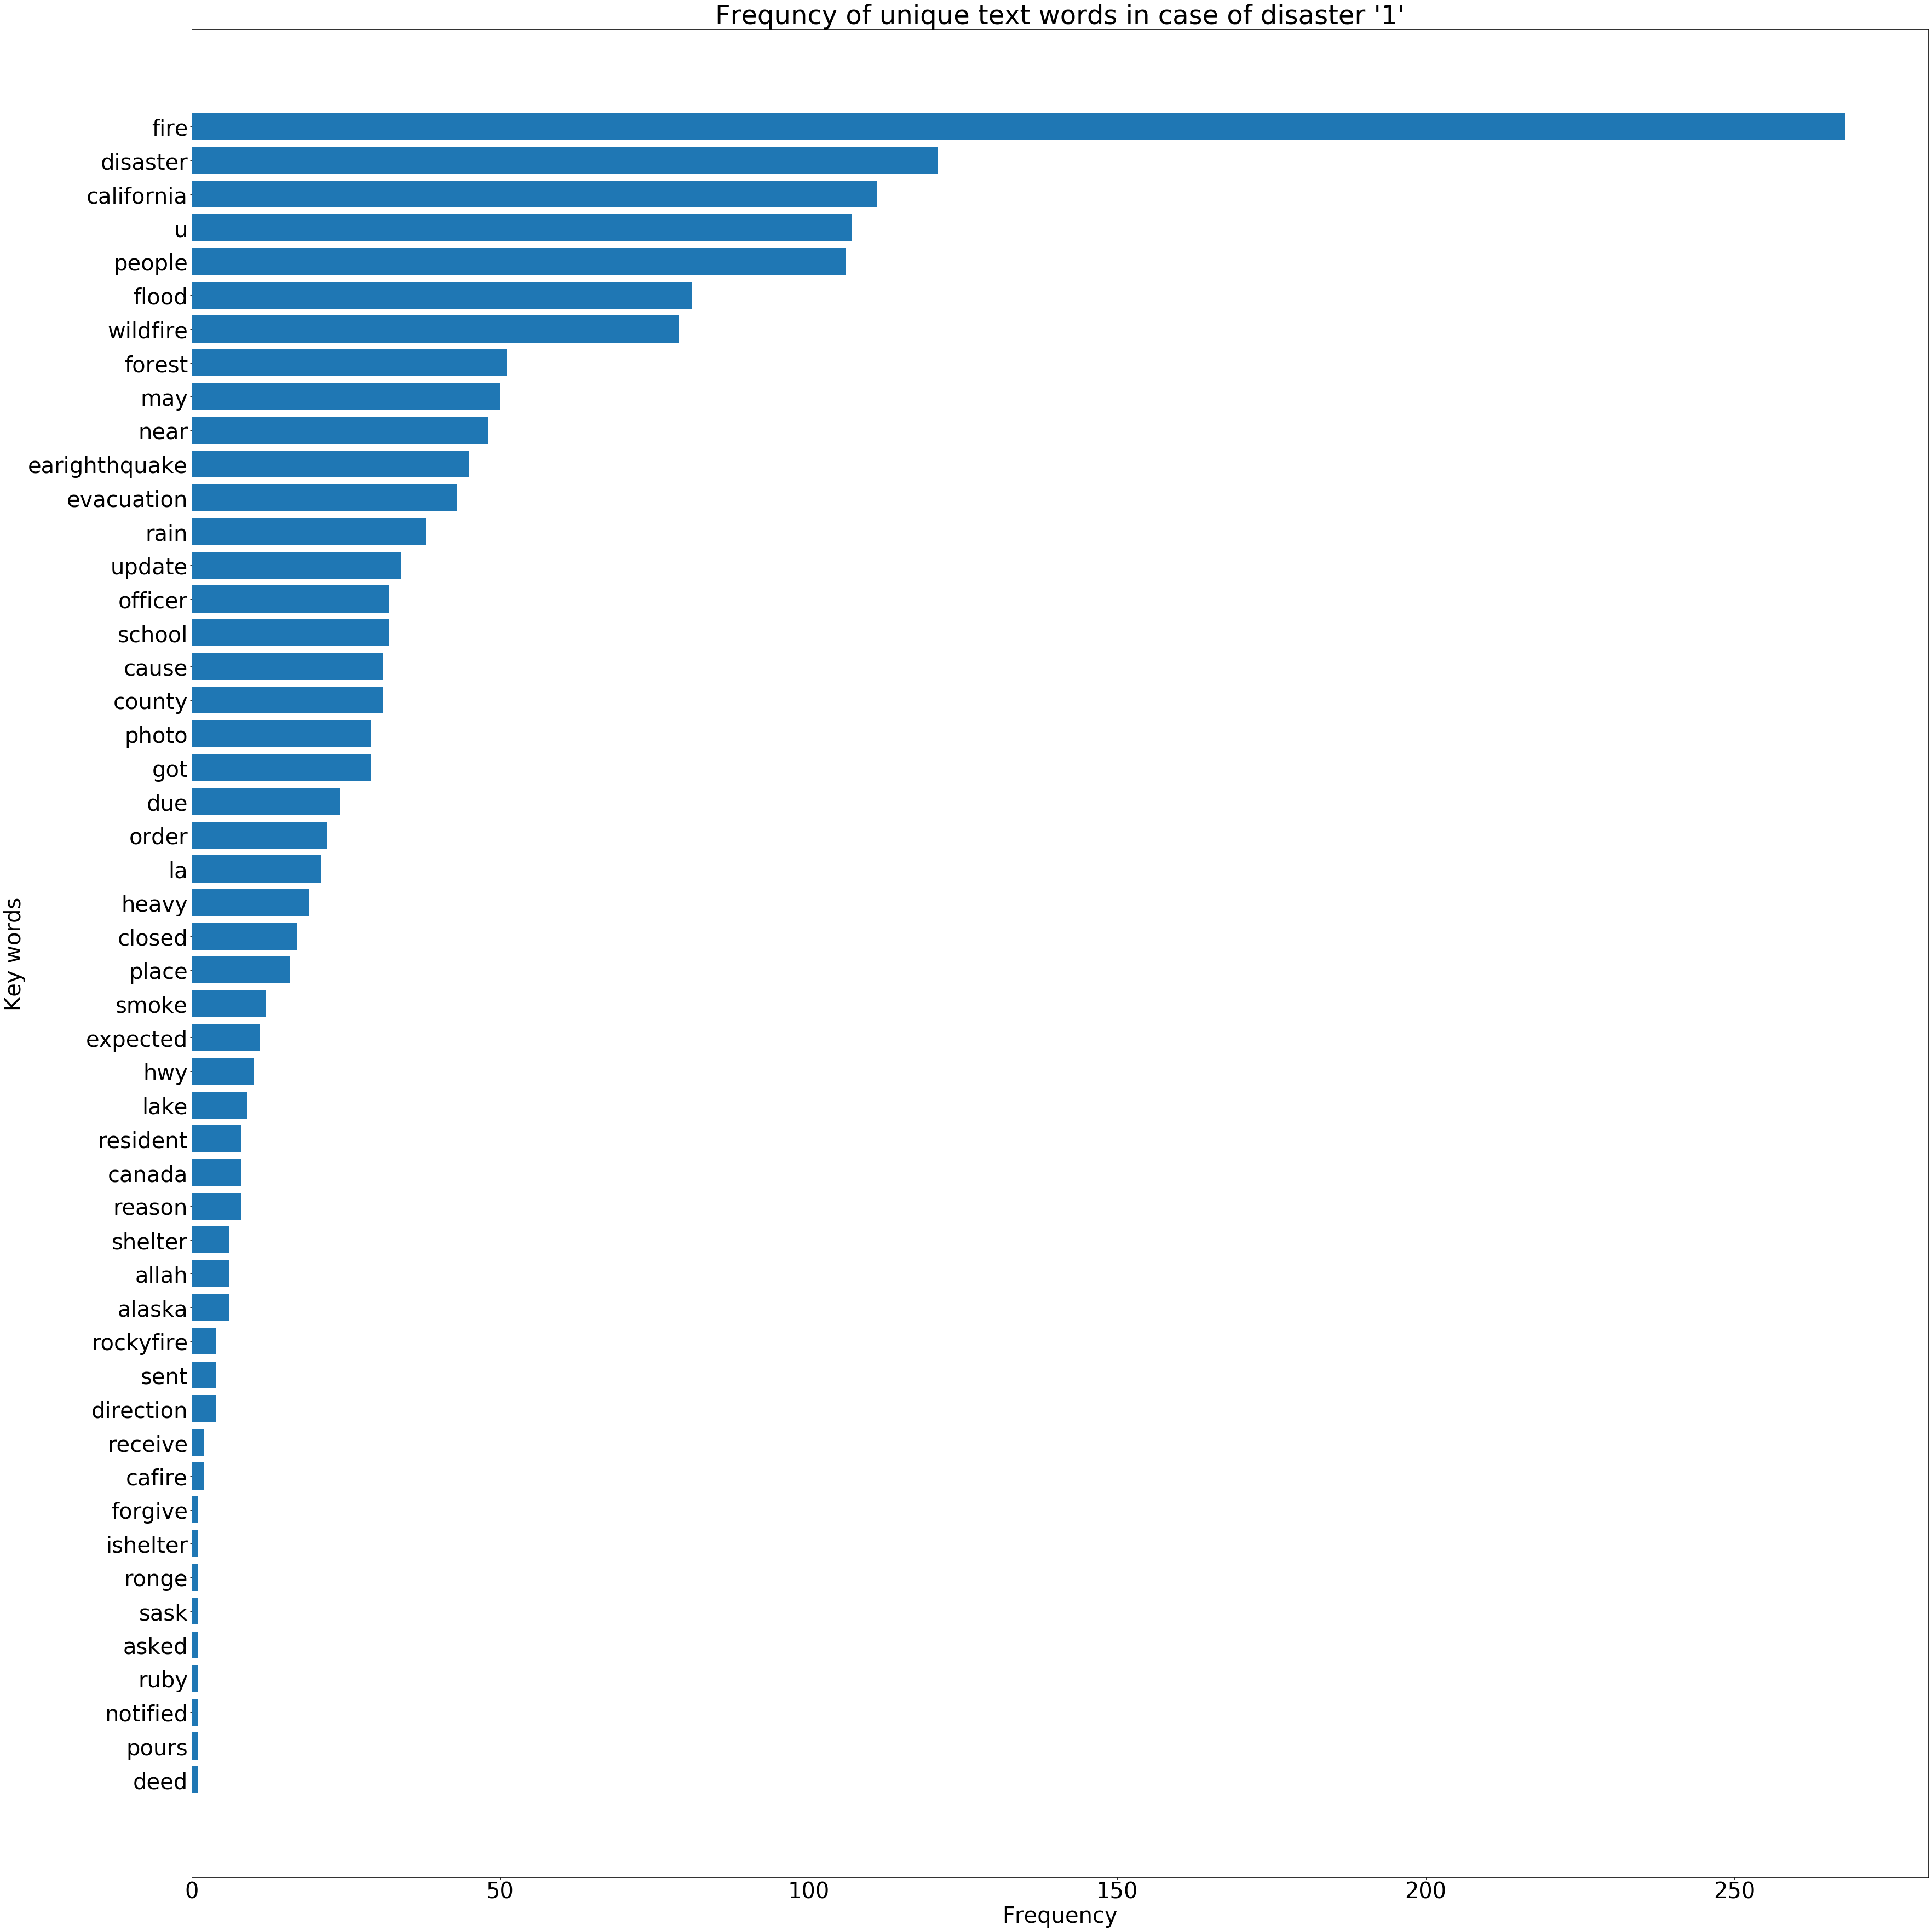

In [19]:
# Frequency plots of unique keywords for disaster class '1'
keyword_frequencies = [i for i in tweets_train_data[tweets_train_data['target'] == 1]['text']]
keyword_frequencies = " ".join(keyword_frequencies)
keyword_frequencies = dict(Counter(keyword_frequencies.split()))
keyword_frequencies_df = pd.DataFrame(columns = ['words', 'counts']) 
keyword_frequencies_df['words'] = keyword_frequencies.keys()
keyword_frequencies_df['counts'] = keyword_frequencies.values()
# keyword_frequencies_df.sort_values(by='counts')
# Top 50 keywords and their frequencies 
df = keyword_frequencies_df.iloc[:50,:].sort_values(by='counts')

words = df['words']
y_pos = np.arange(len(words))
count = df['counts']
plt.figure(figsize=(50,50))
plt.barh(y_pos, count,align='center')
plt.yticks(y_pos, words)
plt.xlabel("Frequency")
plt.ylabel("Key words")
plt.title("Frequncy of unique text words in case of disaster '1'")

plt.tight_layout()
plt.show()

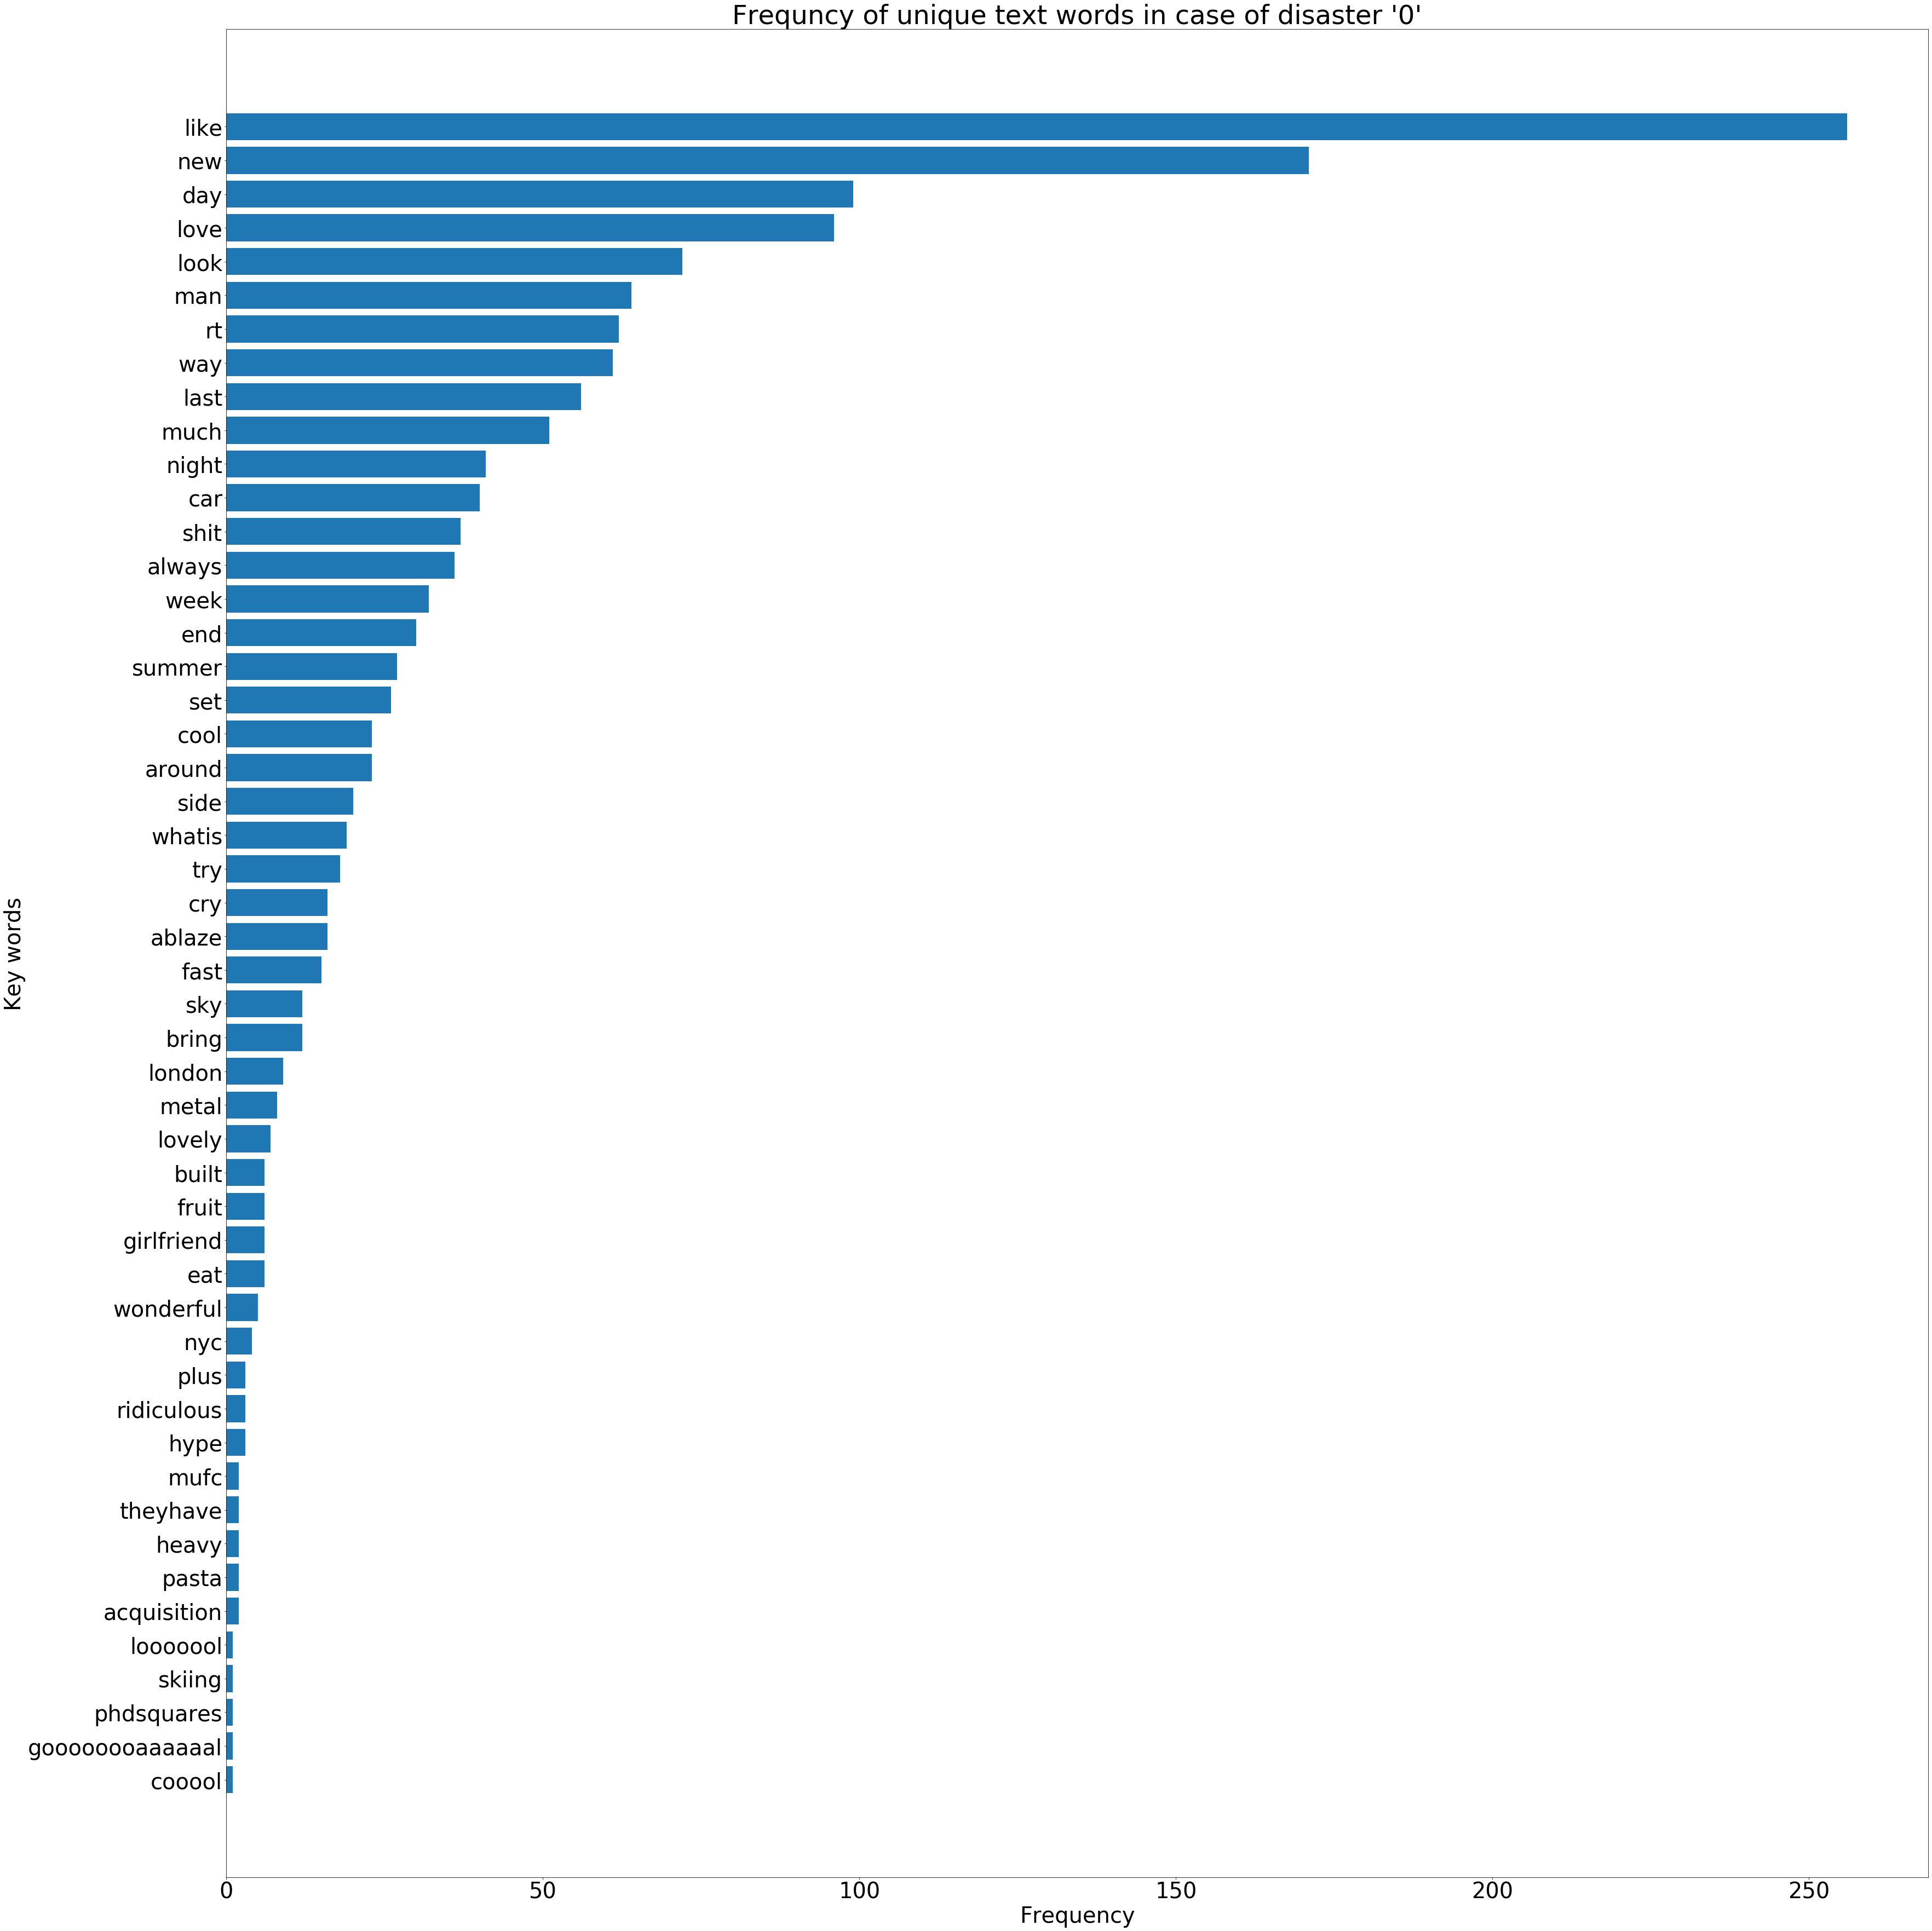

In [20]:
# Frequency plots of unique keywords for disaster class '0'
keyword_frequencies = [i for i in tweets_train_data[tweets_train_data['target'] == 0]['text']]
keyword_frequencies = " ".join(keyword_frequencies)
keyword_frequencies = dict(Counter(keyword_frequencies.split()))
keyword_frequencies_df = pd.DataFrame(columns = ['words', 'counts']) 
keyword_frequencies_df['words'] = keyword_frequencies.keys()
keyword_frequencies_df['counts'] = keyword_frequencies.values()
# keyword_frequencies_df.sort_values(by='counts')
# Top 50 keywords and their frequencies 
df = keyword_frequencies_df.iloc[:50,:].sort_values(by='counts')

words = df['words']
y_pos = np.arange(len(words))
count = df['counts']
plt.figure(figsize=(50,50))
plt.barh(y_pos, count,align='center')
plt.yticks(y_pos, words)
plt.xlabel("Frequency")
plt.ylabel("Key words")
plt.title("Frequncy of unique text words in case of disaster '0'")

plt.tight_layout()
plt.show()